# 2: Explicit ODE Solver

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from TestProblems import *
from Solvers import *
from PlotFunctions import *

## Stability plot for the Explicit Euler method

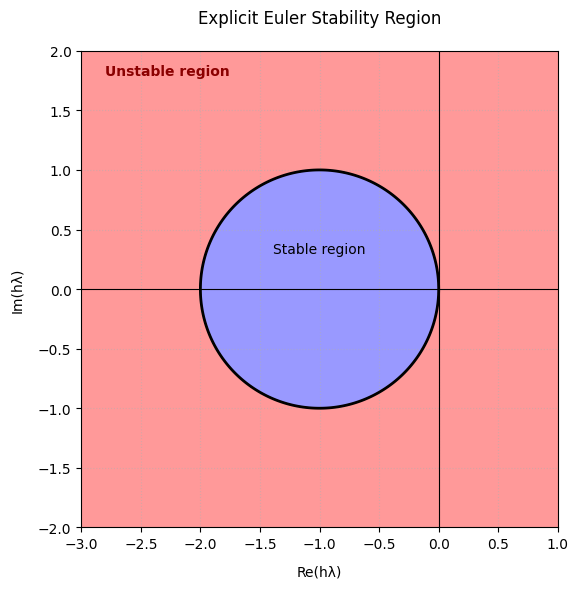

In [2]:
# Create grid in the complex plane
x = np.linspace(-3, 1, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Amplification factor for Explicit Euler: R(z) = 1 + z
R = 1 + Z
R_mag = np.abs(R)

# Create figure
plt.figure(figsize=(7, 6))

# Plot stable (red) and unstable (blue) regions
plt.contourf(X, Y, R_mag <= 1, levels=[0, 0.5, 1.5], 
             colors=['red', 'blue'], alpha=0.4)

# Draw stability boundary (|R(z)| = 1)
plt.contour(X, Y, R_mag, levels=[1], colors='black', linewidths=2)

# Draw unit circle (visual reference)
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta)-1, np.sin(theta), 'k--', lw=1, alpha=0.7)

# Add axes and formatting
plt.axhline(0, color='black', lw=0.8)
plt.axvline(0, color='black', lw=0.8)
plt.title("Explicit Euler Stability Region", pad=20)
plt.xlabel("Re(hλ)", labelpad=10)
plt.ylabel("Im(hλ)", labelpad=10)
plt.gca().set_aspect('equal')

# Add legend and annotations
plt.text(-2.8, 1.8, "Unstable region", color='darkred', weight='bold')
plt.text(-1, 0.3, "Stable region", ha='center', color='black')

plt.grid(True, linestyle=':', alpha=0.5)
plt.xlim(-3, 1)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

## Test algorithms on test problems

### Prey-predator

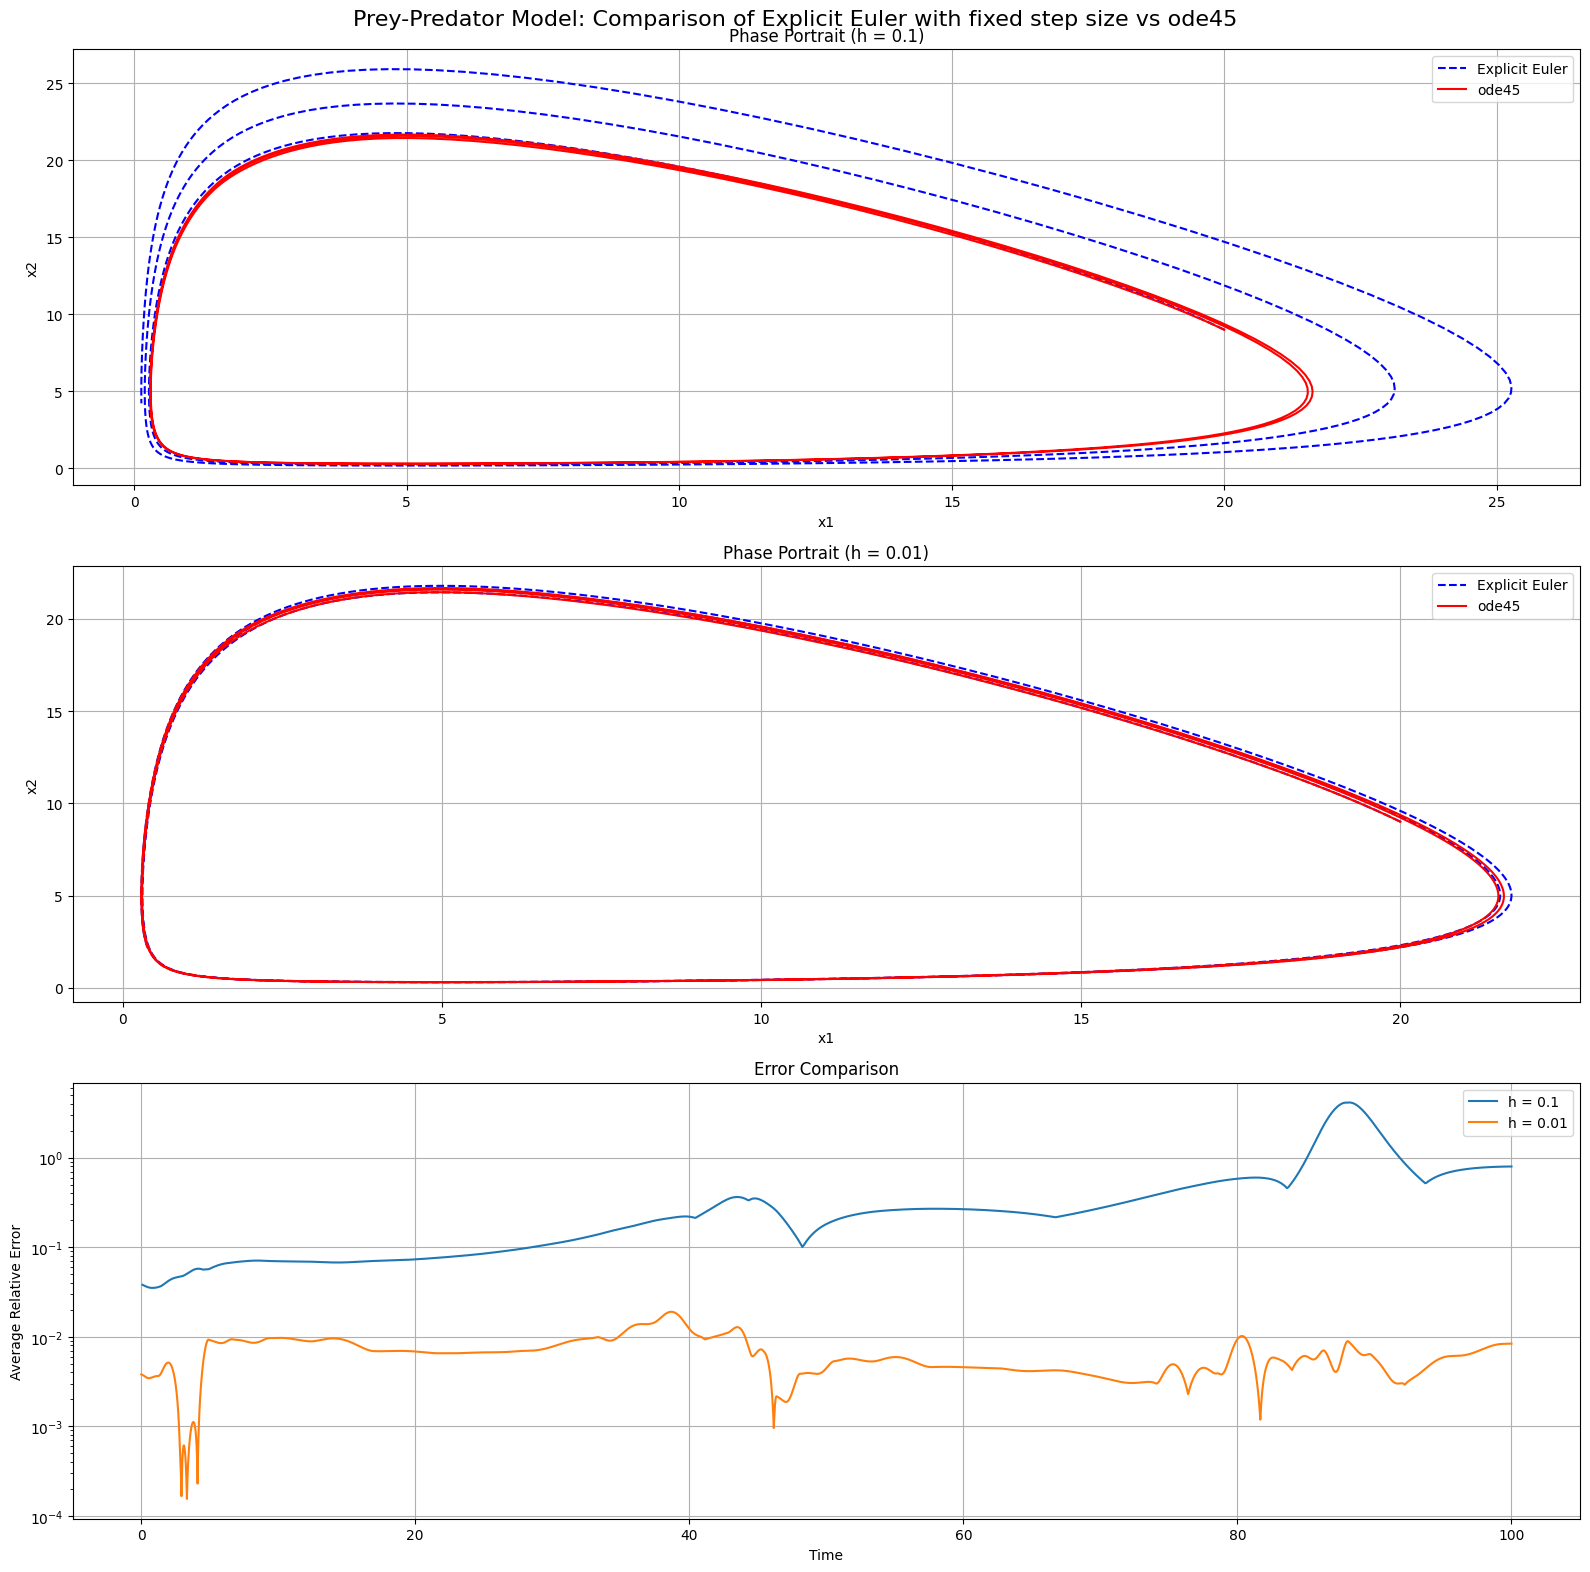

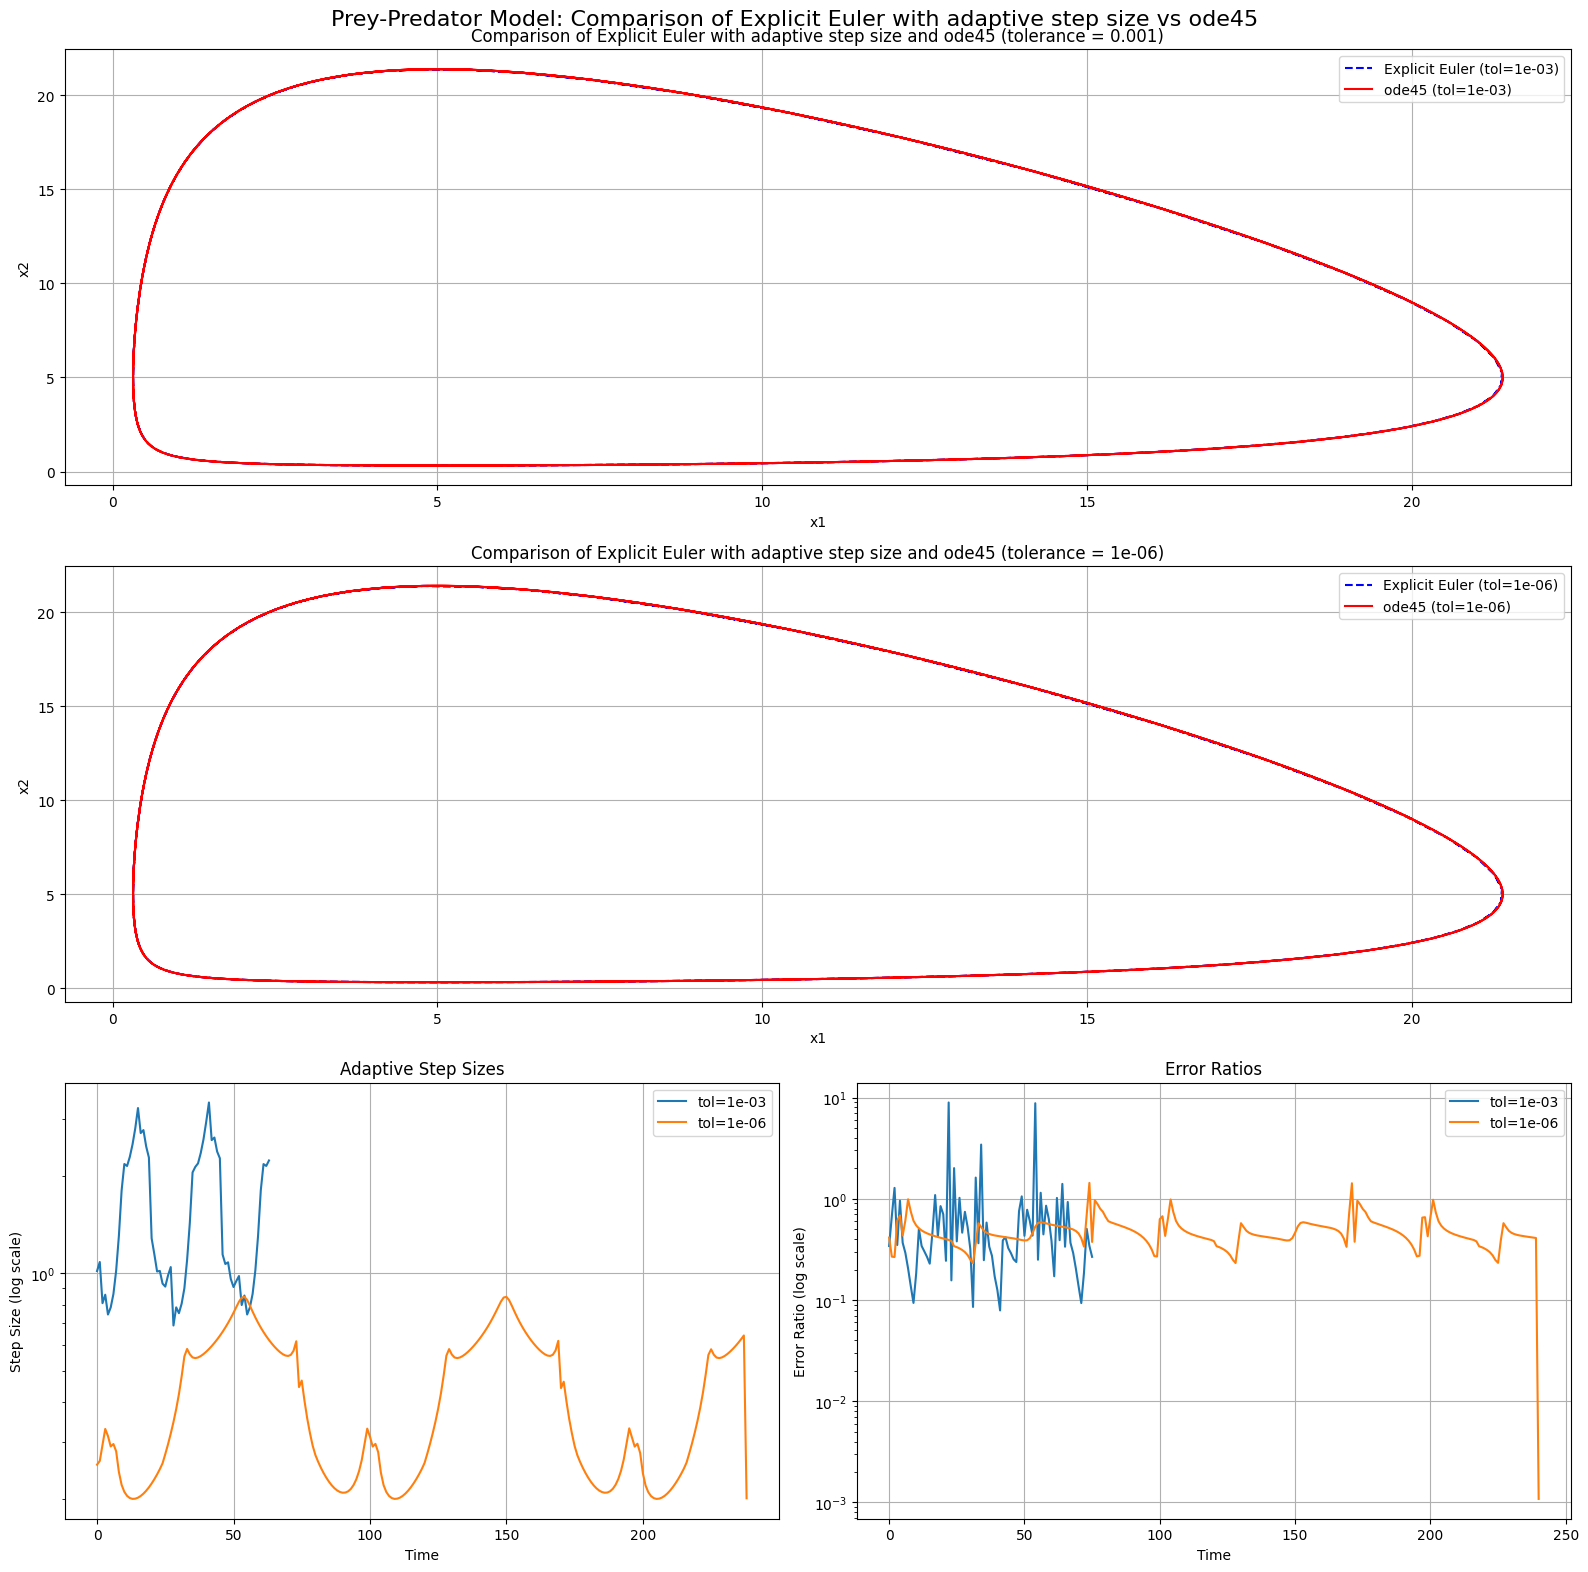

In [3]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate
pp_exp_fixed = compare_solvers(prey_predator_model, t_span, x0, params = (a,b), model_name = "Prey-Predator Model", reference_solver_name="ode45", fixed_steps = True, explicit = True, euler = True)
pp_exp_adaptive = compare_solvers(prey_predator_model, t_span, x0, params = (a,b), model_name = "Prey-Predator Model", reference_solver_name="ode45", steptype = "adaptive", adaptive_steps = True, h0 = 0.01, explicit = True, euler = True)


### CSTR 1 state

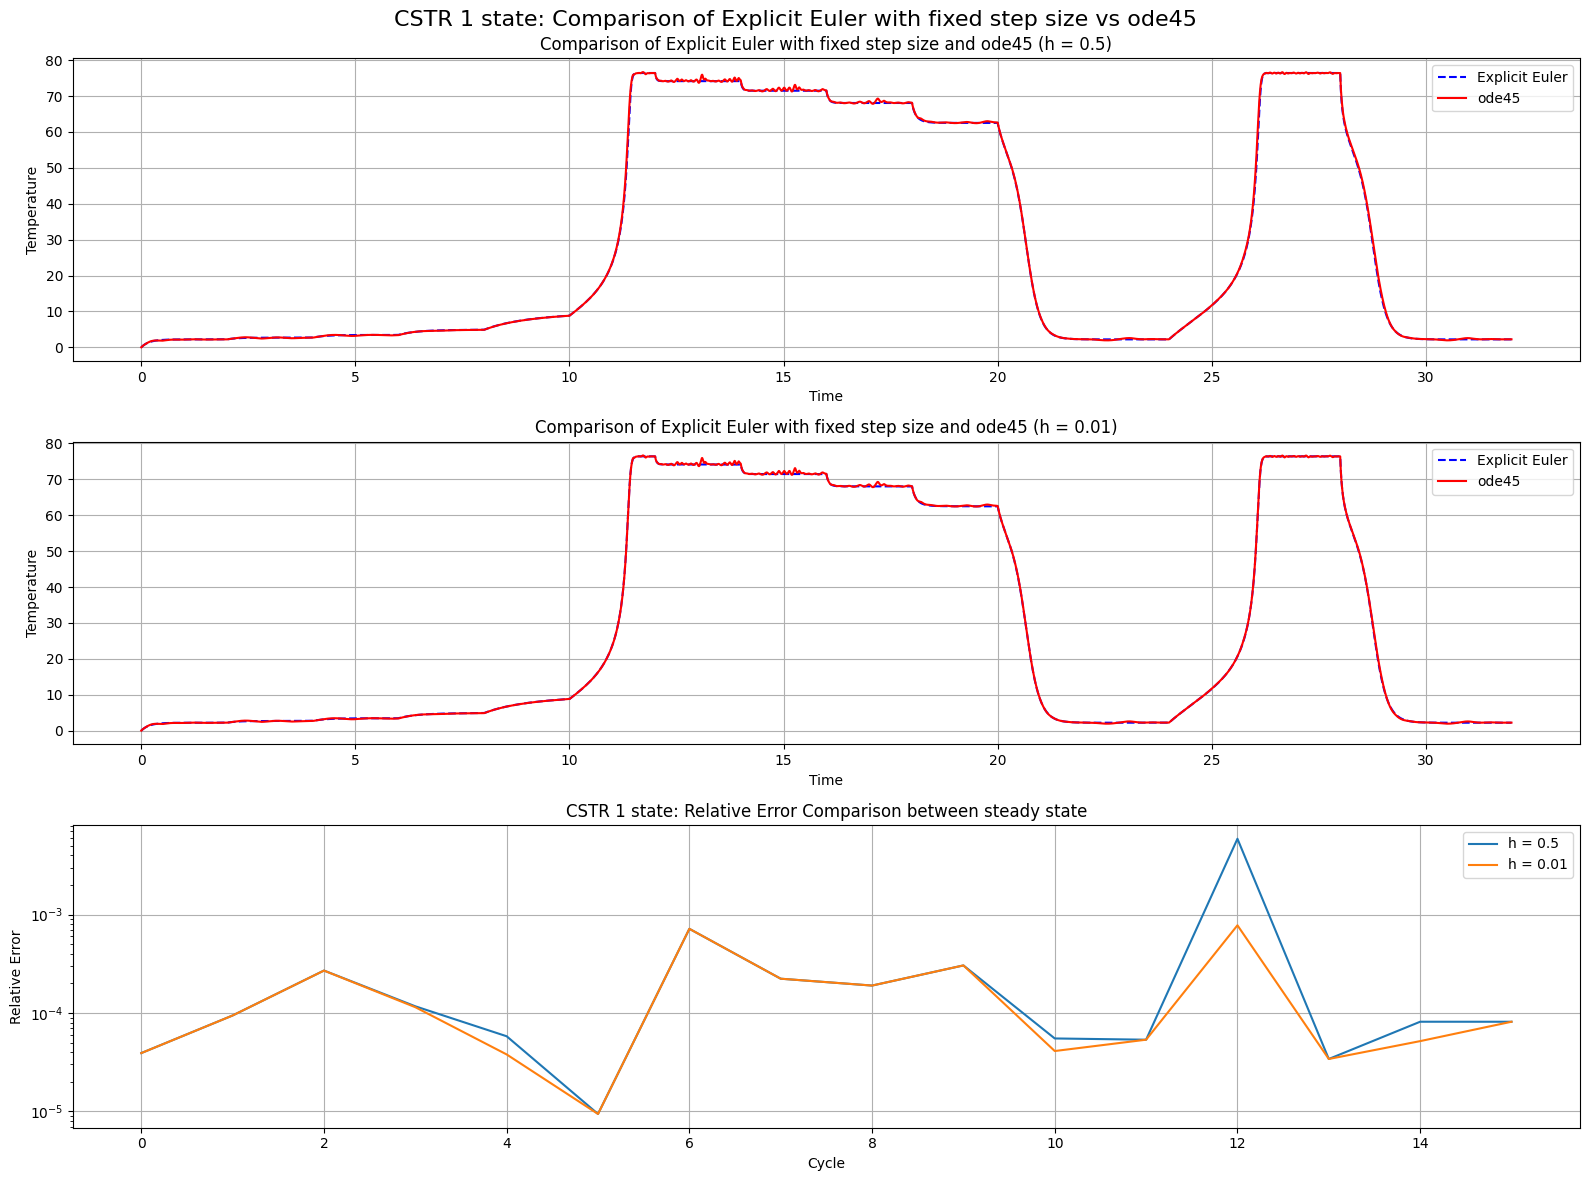

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/Solvers.py:514: RuntimeWarning: divide by zero encountered in scalar divide
  h = min(hmax, max(hmin, 0.9 * h * (epstol / r)**0.2))


<Figure size 1600x1200 with 0 Axes>

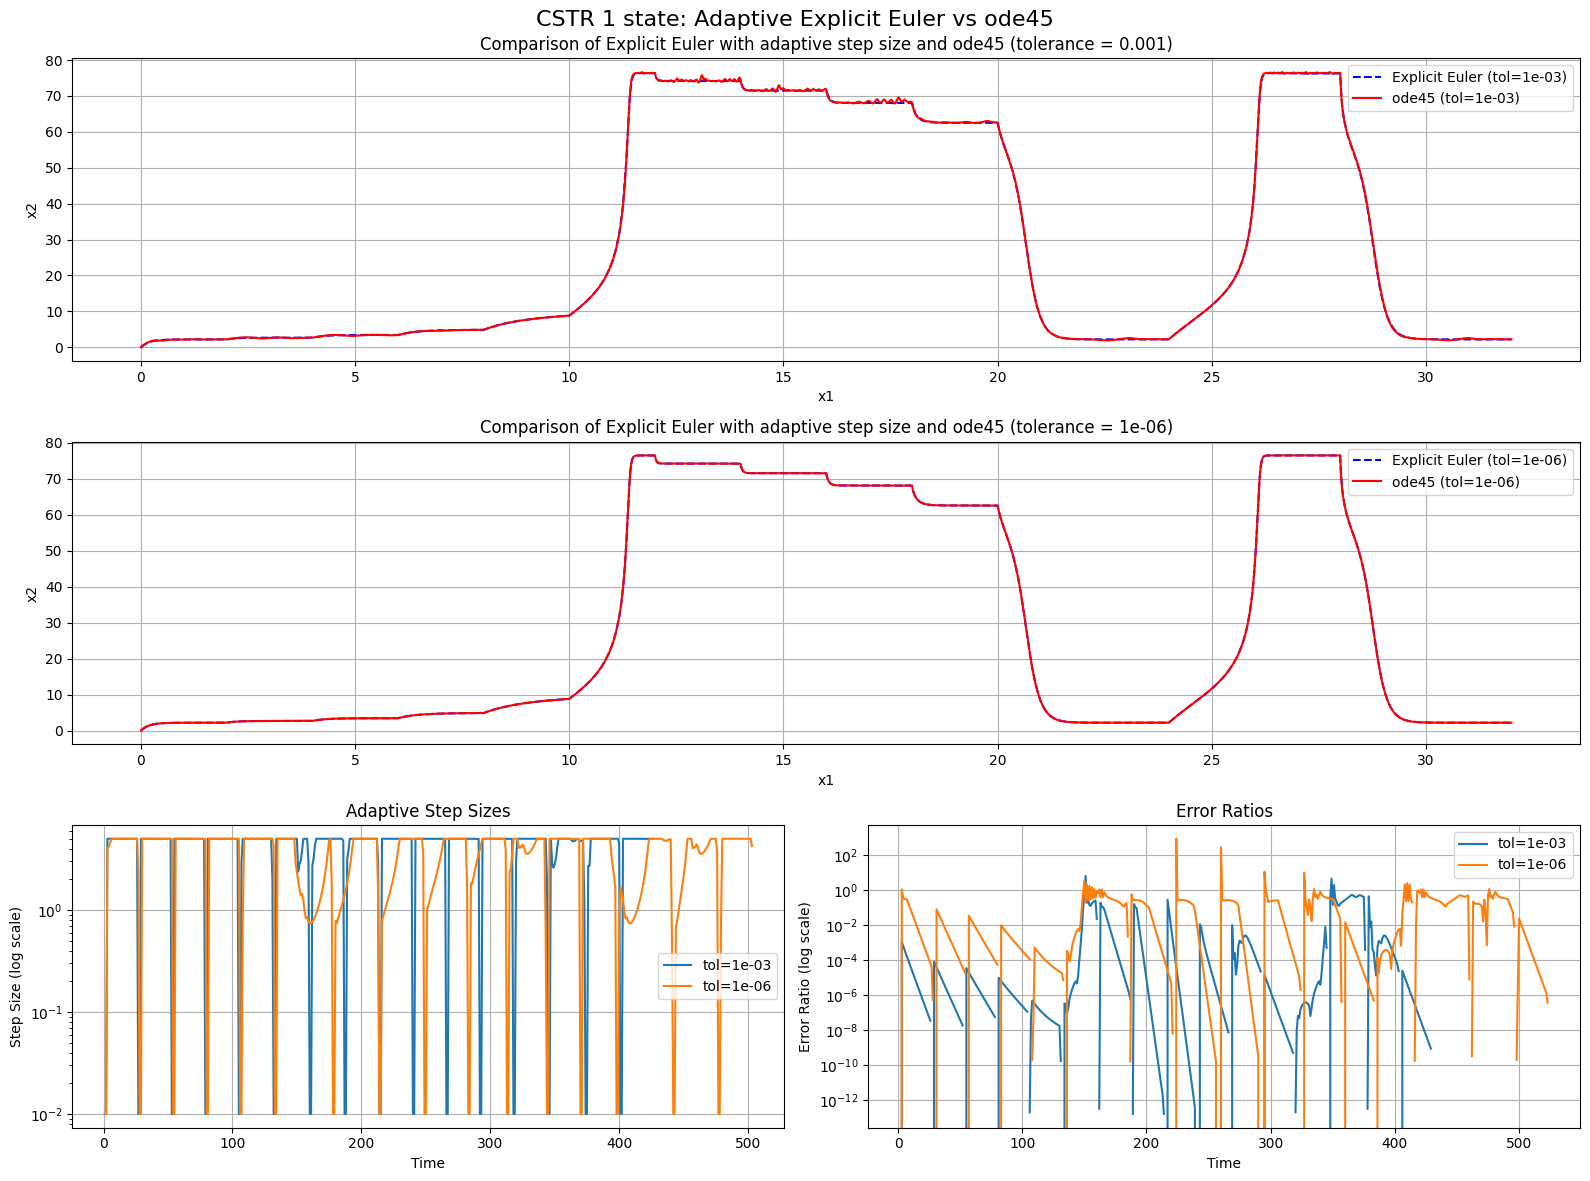

In [4]:
t_span = (0, 120)
cstr_exp_fixed = compare_solvers_cstr(CSTR_1state_model, t_span, model_name = "CSTR 1 state", fixed_steps = True, explicit = True, euler = True, fixed_step_sizes=[0.5, 0.01])
cstr_exp_adaptive = compare_solvers_cstr(CSTR_1state_model, t_span, model_name = "CSTR 1 state", steptype = "adaptive", adaptive_steps = True, h0 = 0.01, explicit = True, euler = True)

### PFR

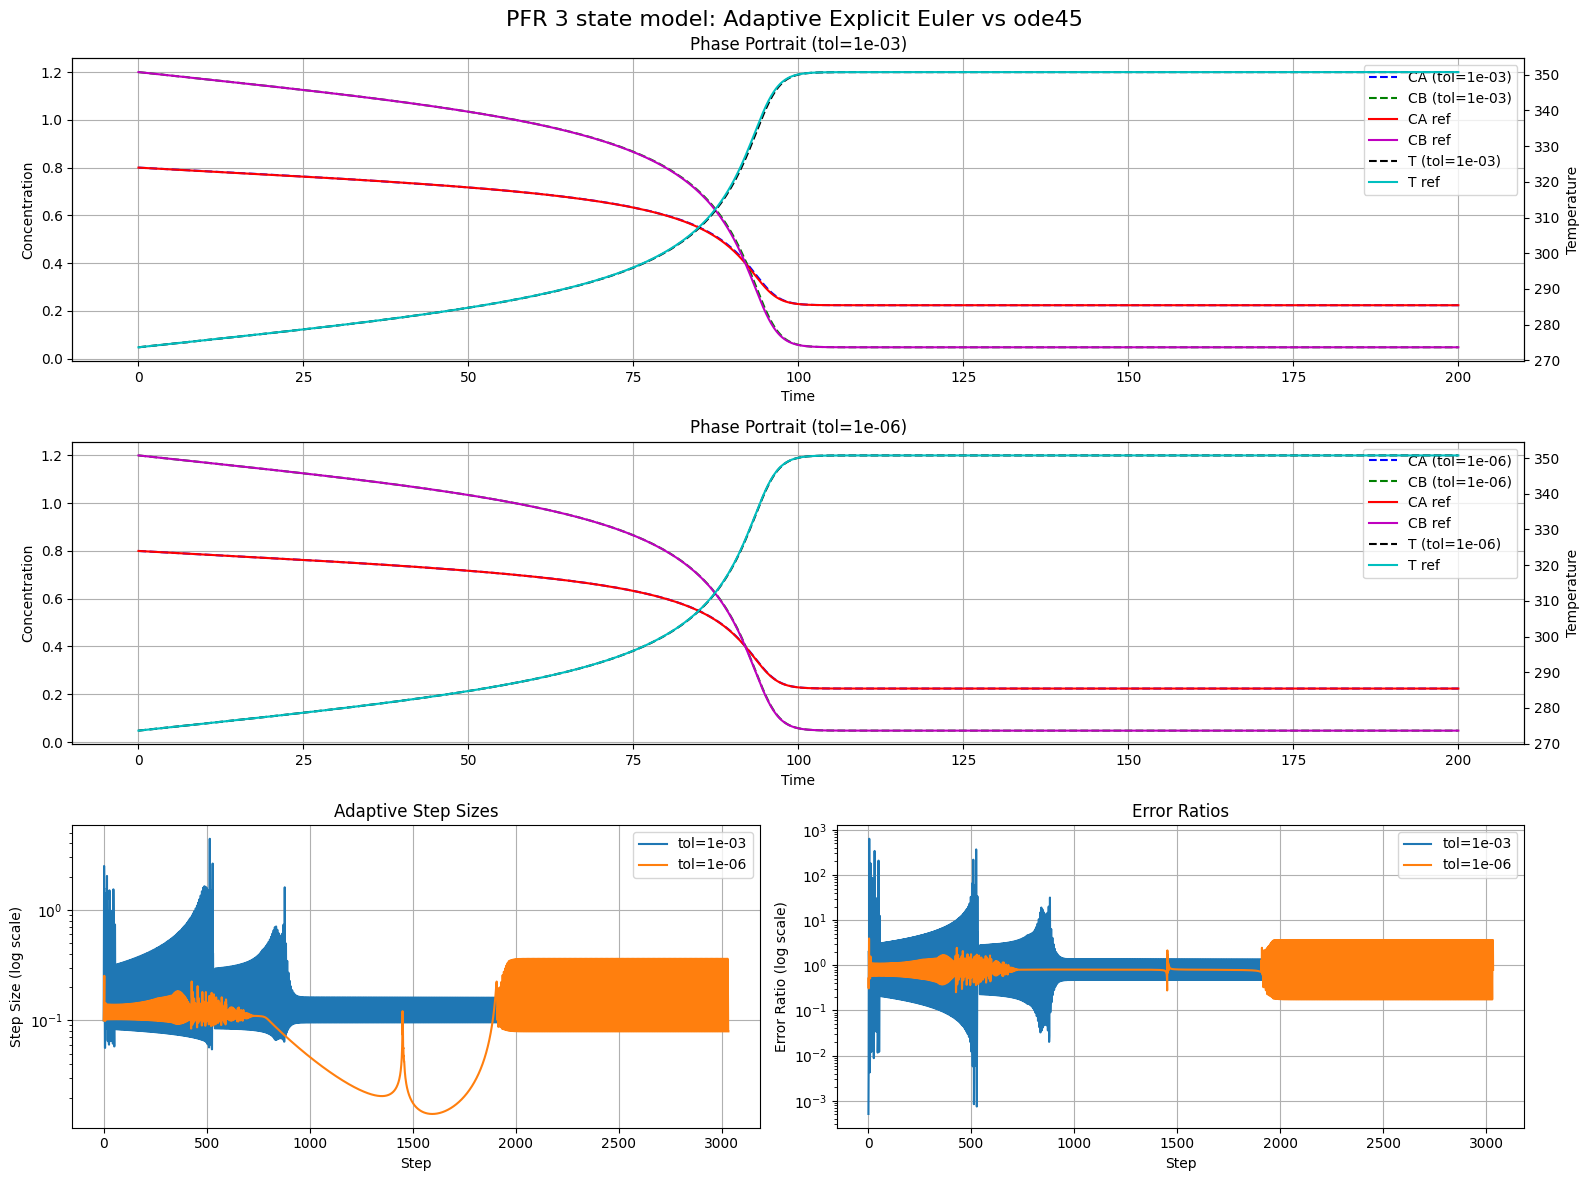

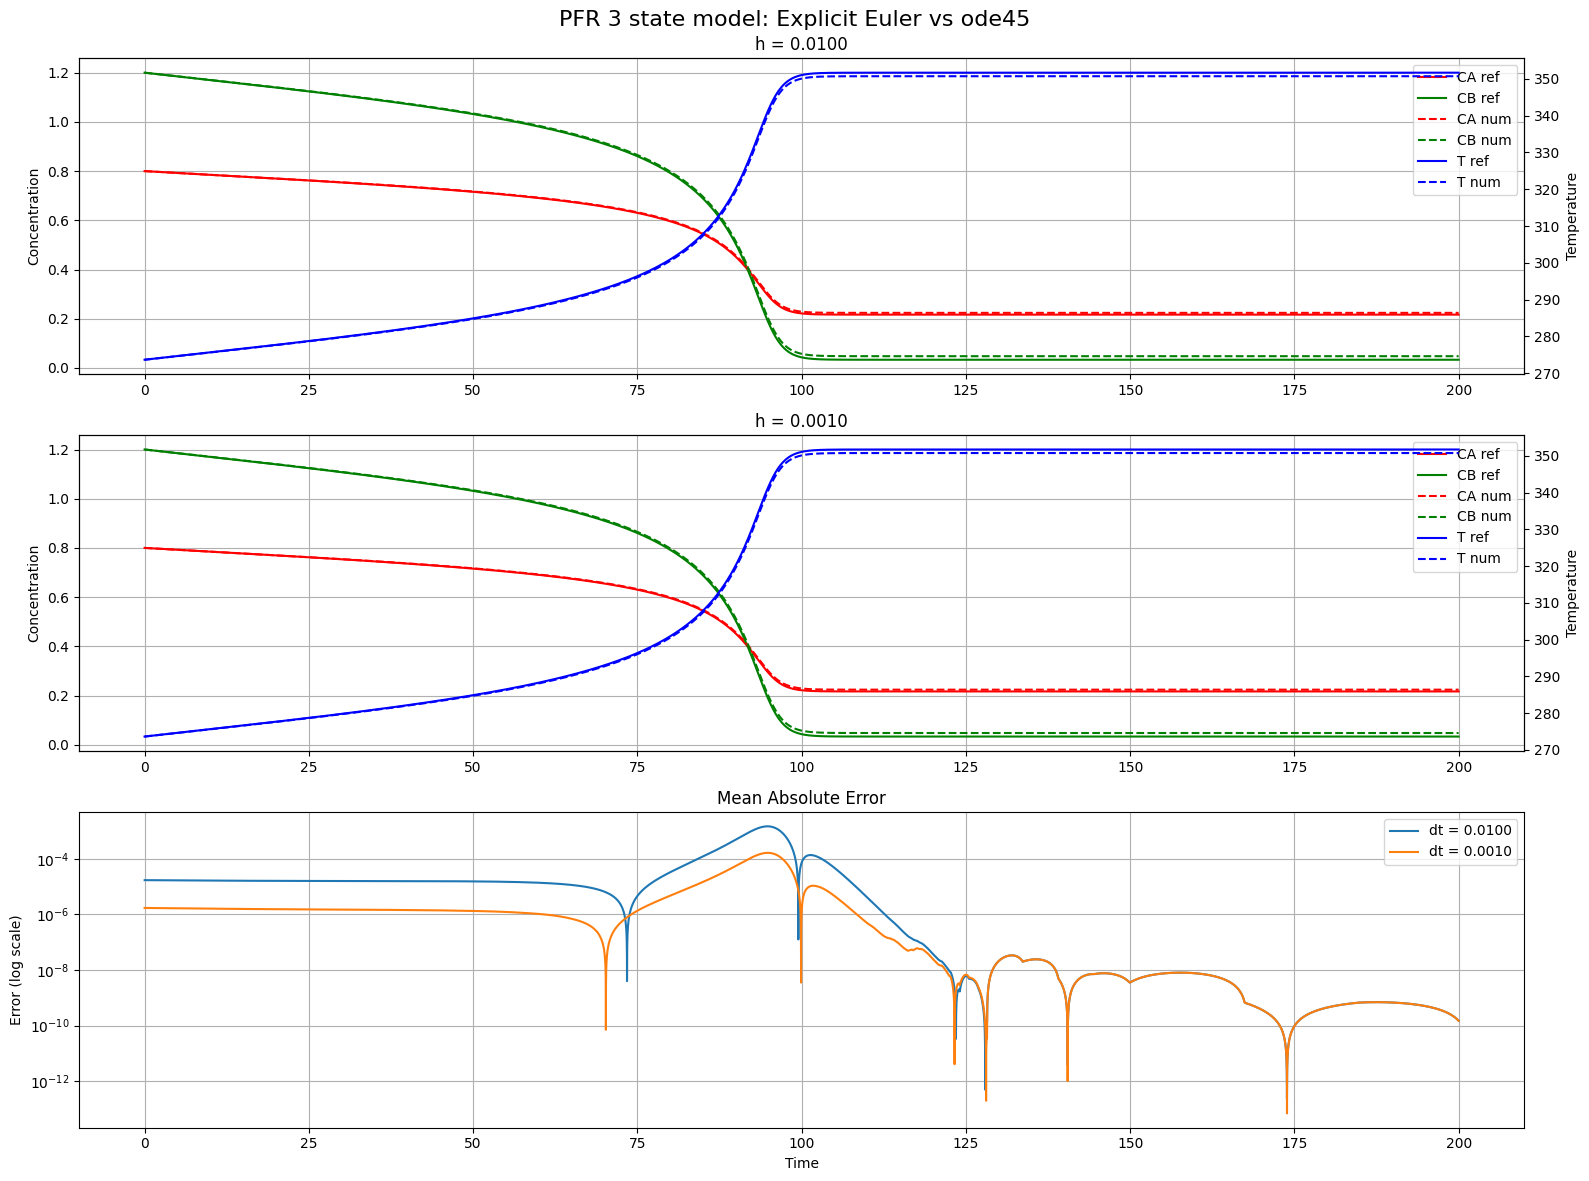

In [5]:
# Initial condition
n = 5  # number of spatial points

Tin = 273.65
CA_in = 1.6 / 2
CB_in = 2.4 / 2
x0 = np.concatenate([
    np.ones(n) * CA_in,    # CA initial
    np.ones(n) * CB_in,    # CB initial
    Tin*np.ones(n)  # T initial
])
t_span = (0, 200)

pfr_exp_adaptive = compare_solvers_pfr(PFR_3state_model, t_span, x0, model_name = "PFR 3 state model", reference_solver_name="ode45", adaptive_steps = True, explicit = True, euler = True, n = n)
pfr_exp_fixed = compare_solvers_pfr(PFR_3state_model, t_span, x0, model_name = "PFR 3 state model", reference_solver_name="ode45", fixed_steps = True, explicit = True, euler = True, n = n, fixed_step_sizes=[0.01, 0.001])

## Summary

In [6]:
print("Explicit Euler with addaptive steps:")
print("")
print("Prey-Predator Model, tolerance = 0.001")
print("Accepted steps: ", pp_exp_adaptive[0.001]['n_accept'])
print("Rejected steps: ", pp_exp_adaptive[0.001]['n_reject'])
print("Total number of steps: ", pp_exp_adaptive[0.001]['n_accept'] + pp_exp_adaptive[0.001]['n_reject'])
print("Total number of steps for ode45: ", pp_exp_adaptive[0.001]['ref_nfun'])
print("Prey-Predator Model, tolerance = 1e-6")
print("Accepted steps: ", pp_exp_adaptive[1e-6]['n_accept'])
print("Rejected steps: ", pp_exp_adaptive[1e-6]['n_reject'])
print("Total number of steps: ", pp_exp_adaptive[1e-6]['n_accept'] + pp_exp_adaptive[1e-6]['n_reject'])
print("Total number of steps for ode45: ", pp_exp_adaptive[1e-6]['ref_nfun'])
print("")
print("CSTR 1 state, tolerance = 0.001")
print("Accepted steps: ", cstr_exp_adaptive[0.001]['n_accept'])
print("Rejected steps: ", cstr_exp_adaptive[0.001]['n_reject'])
print("Total number of steps: ", cstr_exp_adaptive[0.001]['n_accept'] + cstr_exp_adaptive[0.001]['n_reject'])
print("Total number of steps for ode15s: ", cstr_exp_adaptive[0.001]['ref_nfun'])
print("CSTR 1 state, tolerance = 1e-6")
print("Accepted steps: ", cstr_exp_adaptive[1e-6]['n_accept'])
print("Rejected steps: ", cstr_exp_adaptive[1e-6]['n_reject'])
print("Total number of steps: ", cstr_exp_adaptive[1e-6]['n_accept'] + cstr_exp_adaptive[1e-6]['n_reject'])
print("Total number of steps for ode15s: ", cstr_exp_adaptive[1e-6]['ref_nfun'])
print("")
print("PFR 3 state, tolerance = 0.001")
print("Accepted steps: ", pfr_exp_adaptive[0.001]['n_accept'])
print("Rejected steps: ", pfr_exp_adaptive[0.001]['n_reject'])
print("Total number of steps: ", pfr_exp_adaptive[0.001]['n_accept'] + pfr_exp_adaptive[0.001]['n_reject'])
print("Total number of steps for ode45: ", pfr_exp_adaptive[0.001]['ref_nfun'])
print("PFR 3 state, tolerance = 1e-6")
print("Accepted steps: ", pfr_exp_adaptive[1e-6]['n_accept'])
print("Rejected steps: ", pfr_exp_adaptive[1e-6]['n_reject'])
print("Total number of steps: ", pfr_exp_adaptive[1e-6]['n_accept'] + pfr_exp_adaptive[1e-6]['n_reject'])
print("Total number of steps for ode45: ", pfr_exp_adaptive[1e-6]['ref_nfun'])

Explicit Euler with addaptive steps:

Prey-Predator Model, tolerance = 0.001
Accepted steps:  65
Rejected steps:  12
Total number of steps:  77
Total number of steps for ode45:  242
Prey-Predator Model, tolerance = 1e-6
Accepted steps:  240
Rejected steps:  2
Total number of steps:  242
Total number of steps for ode45:  734

CSTR 1 state, tolerance = 0.001
Accepted steps:  410
Rejected steps:  3
Total number of steps:  413
Total number of steps for ode15s:  1148
CSTR 1 state, tolerance = 1e-6
Accepted steps:  897
Rejected steps:  23
Total number of steps:  920
Total number of steps for ode15s:  2914

PFR 3 state, tolerance = 0.001
Accepted steps:  1545
Rejected steps:  775
Total number of steps:  2320
Total number of steps for ode45:  614
PFR 3 state, tolerance = 1e-6
Accepted steps:  2455
Rejected steps:  580
Total number of steps:  3035
Total number of steps for ode45:  614
